# Classification. Linear models and KNN

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score, roc_auc_score, make_scorer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, Normalizer
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingClassifier
from sklearn.base import BaseEstimator, TransformerMixin

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [ ]:
PATH = "https://storage.googleapis.com/kagglesdsdata/competitions/3136/26502/train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1614604779&Signature=jlyXM0MDSxtcmftKwxn4q6izZ2QkEn0TwC1iu70tqOahQcMB%2FcYMgxGoh3XcFlM2vshCkO2dYGgRo6NTkefHz2FosyyLePmXRHAPpDhYyYY0ajTuHwA%2FtmMfKLcU0LkYbSgFvTcc2LA3gh8pphkGfJZlGX9RnQ%2B8HGwqvQBC7b0Nhaod1wvvNpfSNUlFD3FWy63%2FDYETpg7dIgLOnGUpmsV3pjGDM4Rf3oYK3UeyN57JlMGX5OMDUhmdY2LRZR8CaNuECyPPlHf25kdJLnhtNaVtcu73mKUfC9gW7LHJPzsYOtBQSdGx5rtsqSQenFgu%2BVzR2%2Bwgw5nEZ8TmGHHQxg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv"

In [ ]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [ ]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [ ]:
sex = data['Sex'].value_counts()
f'{sex.female} females and {sex.male} males in the dataset'

'314 females and 577 males in the dataset'

In [ ]:
survived = data['Survived'].value_counts()
f'{survived[1]} people survived and {survived[0]} dead in the dataset'

'342 people survived and 549 dead in the dataset'

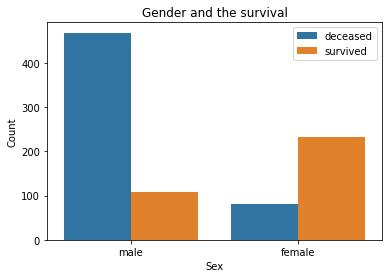

In [ ]:
cp = sns.countplot(x='Sex', hue='Survived', data=data)
cp.set_xticklabels(['male', 'female'])
cp.legend(['deceased', 'survived'])
plt.title('Gender and the survival')
plt.ylabel('Count')
plt.show()

There is a definite connection between sex and the survivors. There are far more female survivors than men. I assume that women were put in the boats in the first place.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

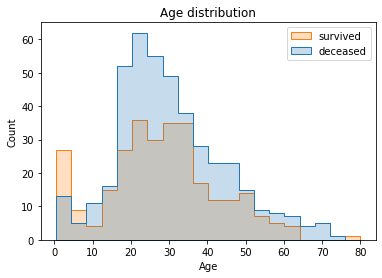

In [ ]:
sns.histplot(data, x='Age', element='step', hue='Survived',)
plt.legend(['survived', 'deceased'])
plt.title('Age distribution')
plt.show()

In [ ]:
age_mean = (np.round(data[data['Survived']==0]['Age'].mean(), 2), np.round(data[data['Survived']==1]['Age'].mean(), 2))
age_median = (np.round(data[data['Survived']==0]['Age'].median(), 2), np.round(data[data['Survived']==1]['Age'].median(), 2))
print(f'Average age survived passengers = {age_mean[1]}, average age deceased passengers = {age_mean[0]}')
print(f'Median age survived passengers = {age_median[1]}, median age deceased passengers = {age_median[0]}')

Average age survived passengers = 28.34, average age deceased passengers = 30.63
Median age survived passengers = 28.0, median age deceased passengers = 28.0


The relationship between survival and age is very weak. At the same time, it should be noted that the number of surviving infants is much higher. The mortality rate in middle age is much higher, but this is probably due to the fact that women with children and the elderly were put in the boat first. Middle-aged though physically strong, it was extremely difficult to survive without a dinghy.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

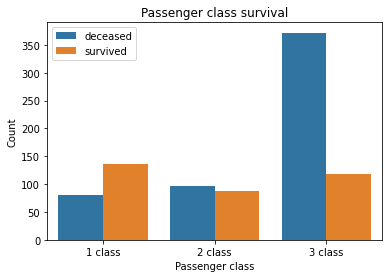

In [ ]:
cp = sns.countplot(data=data, x='Pclass', hue='Survived')
cp.set_xticklabels(['1 class', '2 class', '3 class'])
cp.legend(['deceased', 'survived'])
plt.xlabel('Passenger class')
plt.ylabel('Count')
plt.title('Passenger class survival')
plt.show()

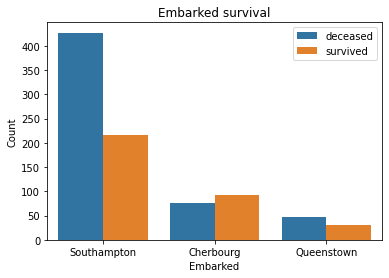

In [ ]:
cp = sns.countplot(data=data, x='Embarked', hue='Survived')
cp.set_xticklabels(['Southampton', 'Cherbourg', 'Queenstown'])
cp.legend(['deceased', 'survived'])
plt.ylabel('Count')
plt.title('Embarked survival')
plt.show()

The safest is the first class. It is also connected with the order of boarding the boats. The safest port is Cherbourg, most likely due to the wealth of the population in this area.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

Percentage of missing values:
Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64


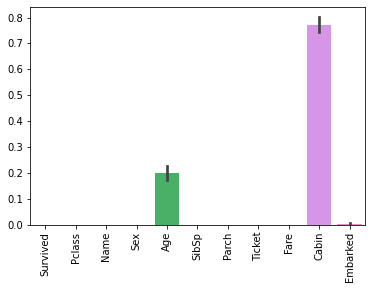

In [ ]:
print('Percentage of missing values:')
print(data.isnull().sum()/data.shape[0]*100)
bp = sns.barplot(data=data.isnull())
plt.setp(bp.get_xticklabels(), rotation=90)
plt.show()

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Missing values were found at the age of 20%, cabin 77%, port 0.2%. In the context of the port, the amount of missing data is not very much and therefore they can be deleted, but you can still use the most common one. I will replace the missing values with Southampton (S) since most people have left from there. But I probably won't use the port in training, since the cabin class is a more significant feature of this type. The age is missing 20%, replacing them with the average value or deleting them would be unwise, it may turn out better if we use the forecast for the passenger status in the name column. The cabin would be a pretty strong indication when studying the ship's plan, but it won't be possible to reconstruct the cabin number from the available data, so we won't use the cabin.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [ ]:
y = data['Survived']

In [ ]:
# functions for preparing features
def status_extrackt(data):
  data['Status'] = data['Name'].str.extract(r'(\w+\.)')
  return data
def fix_age(train, test = None):
  if test is None:
    data = train
  else:
    data = test
  for i in train['Status'].unique():
    for j in train['Sex'].unique():
      for k in train['Pclass'].unique():
        temp = train.loc[((train['Status']==i) & (train['Sex'] == j) & (train['Pclass'] == k)), 'Age'].median()
        data.loc[((data['Status']==i) & (data['Sex'] == j) & (data['Pclass'] == k)), 'Age'] = data.loc[((data['Status']==i) & (data['Sex'] == j) & (data['Pclass'] == k)), 'Age'].fillna(temp)
  if test is None:
    return data, train
  return data
def one_hot_encoding(data, param, encoder=None, fit=False, drop=None):
  data = data.reset_index()
  if encoder is None:
    encoder = OneHotEncoder(sparse=False, drop=drop)
    fit = True
  if fit:
    encoder.fit(data[param].values.reshape(-1, 1))
  new_features = encoder.transform(data[param].values.reshape(-1, 1))
  new_features = pd.DataFrame(new_features, columns=[param + str(i) for i in range(new_features.shape[1])])
  data = pd.concat([data, new_features], axis=1)
  data = data.set_index('PassengerId')
  data = data.drop(param, axis=1)
  if fit:
    return data, encoder
  return data
def sex_encode(data):
  data['nSex'] = 0
  data.loc[data['Sex'] == 'male', 'nSex'] = 1
  data = data.drop('Sex', axis=1)
  return data
def status_encode(data):
  data['Mr'] = data['Status'].str.match('Mr\.').astype(int)
  data['Miss'] = data['Status'].str.match('Miss\.').astype(int)
  data['Mrs'] = data['Status'].str.match('Mrs\.').astype(int)
  data['Master'] = data['Status'].str.match('Master\.').astype(int)
  return data

In [ ]:
# preparing train features
train = status_extrackt(data)
train['Embarked'] = train['Embarked'].fillna('S')
train, fitten_train = fix_age(train)
train = sex_encode(train)
train = status_encode(train)
train, embarked_encoder = one_hot_encoding(train, 'Embarked', drop='first')
train['Family'] = train['SibSp'] + train['Parch']
train.head()

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Status,nSex,Mr,Miss,Mrs,Master,Embarked0,Embarked1,Family
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,Mr.,1,1,0,0,0,0.0,1.0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,Mrs.,0,0,0,1,0,0.0,0.0,1
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,Miss.,0,0,1,0,0,0.0,1.0,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,Mrs.,0,0,0,1,0,0.0,1.0,1
5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,Mr.,1,1,0,0,0,0.0,1.0,0


In [ ]:
futures_clf = ['nSex', 'Age', 'Pclass', 'Mr', 'Miss', 'Mrs', 'Master', 'Embarked0', 'Embarked1', 'Fare', 'SibSp',	'Parch', 'Family']
X = train[futures_clf]
cv = KFold(5, random_state=42, shuffle=True)

In [ ]:
# custom class for selecting features
class FeatureSelector(BaseEstimator, TransformerMixin):
  def __init__(self, columns):
    self.columns = columns

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return X[self.columns]

In [ ]:
# the best parameters for LogisticRegression are selected based on research, the extra code is removed, for your convenience
best_clf = Pipeline(memory=None,
         steps=[('selector',
                 FeatureSelector(columns=['Pclass', 'Mr', 'Miss', 'Mrs', 'Master', 'Age', 'Embarked0', 'Embarked1', 'Family'])),
                ('scaler', MinMaxScaler()),
                ('clf',
                 LogisticRegression(C=1.65, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=-1, penalty='l2', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
clf_cv = cross_validate(best_clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, verbose=3, return_train_score=True, return_estimator=True)
clf_cv['test_score'].mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


0.8294143493817087

In [ ]:
clf_cv['test_score'].mean()

0.8294143493817087

In [ ]:
# the best parameters for KNeighborsClassifier are selected based on research, the extra code is removed, for your convenience
best_knn = Pipeline(steps=[('selector',
                 FeatureSelector(columns=['Pclass', 'Mr', 'Miss', 'Embarked0', 'Embarked1'])),
                ('norm', Normalizer()),
                ('knn',
                 KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                      metric='mahalanobis', metric_params=None,
                                      n_jobs=-1, n_neighbors=23, p=2,
                                      weights='uniform'))],
         verbose=False)
knn_cv = cross_validate(best_knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1, verbose=3, return_train_score=True)
knn_cv['test_score'].mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


0.8148264390182662

In [ ]:
knn_cv['test_score'].mean()

0.8148264390182662

In [ ]:
# training with the use of LogisticRegression and KNeighborsClassifier
estimators = [('clf', best_clf), ('knn', best_knn)]
reg = StackingClassifier(estimators=estimators, cv=cv)
reg.fit(X, y)
predict = reg.predict(X)
accuracy_score(y, predict)

0.8316498316498316

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
PATH = "https://storage.googleapis.com/kagglesdsdata/competitions/3136/26502/test.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1614840177&Signature=E%2B1b0z8IRxLk0ETfKplkiOFZuybN0p8Ju%2F74Dvtv%2FMGiWHpIzUj5gSE7y0QI7Ri7V28tbxtJOzKlp05YdigGpEeic4s46bcDBCpi9KjH7XyV8PuhQ5nDS5xjAqpoOKcSPY7Obmt3VZWi4xyGaICEag%2BcFaeqZTtGzrqjlbckm9eOyoryv7eLZ7GhGTY6luCX4%2Fl7jsEgbhHHlS4eyth3vQCnCLuUck3Jn3YIcTqW4ZGdVfkwT191Z9axXILZF%2BMqJSE4l5ei%2F7O4AsilaLCzJYw85XVB9CYxz3VjGA1mkc1w11ytXDbuWF9b24PD%2FI4KPQ0j5ePxElWUqyYcF0zgcw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv"
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
data_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# preparing test features
test = status_extrackt(data_test)
test['Embarked'] = test['Embarked'].fillna('S')
test = fix_age(fitten_train, test)
test = sex_encode(test)
test = status_encode(test)
test = one_hot_encoding(test, 'Embarked', drop='first', encoder=embarked_encoder)
test['Family'] = test['SibSp'] + test['Parch']
X_test = test[futures_clf]
X_test = X_test.fillna(X_test.median())

In [ ]:
# predicting with LogisticRegression
best_clf.fit(X, y)
predict_test_clf = best_clf.predict(X_test)
test['Survived'] = predict_test_clf
test['Survived'].to_csv('titanik_submission_clf.csv')
test['Survived'].head()

PassengerId
892    0
893    1
894    0
895    0
896    1
Name: Survived, dtype: int64

In [ ]:
# predicting with KNeighborsClassifier
best_knn.fit(X, y)
predict_test_knn = best_knn.predict(X_test)
test['Survived'] = predict_test_knn
test['Survived'].to_csv('titanik_submission_knn.csv')
test['Survived'].head()

PassengerId
892    0
893    0
894    0
895    0
896    0
Name: Survived, dtype: int64

In [ ]:
# predicting with LogisticRegression and KNeighborsClassifier
reg_all = StackingClassifier(estimators=estimators)
reg_all.fit(X, y)
predict_test = reg_all.predict(X_test)
test['Survived']=predict_test
test['Survived'].to_csv('titanik_submission_all.csv')
test['Survived'].head()

PassengerId
892    0
893    1
894    0
895    0
896    1
Name: Survived, dtype: int64

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Мой код был рефакторинг для загрузки в kaggle. Мое имя пользователя: [insafbakirov](https://www.kaggle.com/insafbakirov/). Мой скор в kaggle 0.79186.

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7082/874852/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1614607001&Signature=ZHG2xARTcwC%2FBD%2B0qa5SJA4EcA%2FuWXXBbf4gtn3ksbBT5YMe3P859wNHkbwpMDXgwnUd1V14H3tXqq74ks2I0FBmweBIUp4iVsYY7POa5AxFflgCJ4K5OS0ufSAWTztIGTFgy2kJmCkqJPd9%2Bz6MT4bSUTFDPr8j5coeO3gXcj12ZxkrMhe%2BuPYrI8LBfj5H31HENOqOEWCAhCVEpoIuSvAQYbBbygJ7U1%2FifP4bZ2z8nitjIB5yfiHgaWWJ3BzgpUyRspNQQXMMlJ3jw5UU4Y34Li2a61%2BYAGOhKUp2BacXiFvGwfY%2B2pGQ2kIKj5hMo8BO57EU6WBNvwqgFPxWmA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip').set_index('id')

In [ ]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

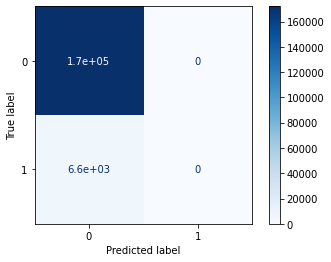

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.765811,0.368

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

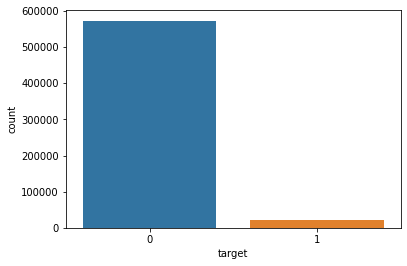

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

Let's say we have a graph of the AUC curve and we will plot the graph using the Normalized Gini Coefficient calculation method. The maximum possible sorting steps during the calculation of the Normalized Gini Coefficient is clearly equal to half the area of the coordinate system AUC of the curve, since the traversal steps during sorting are equal to the coordinate grid. And the number of steps current value is obtained that is equal to the area above the curve AUC -0.5. Half square grid - area above the curve AUC + 0.5. All this is multiplied by 2 equals Normalized Gini Coefficient.

**(0.5 points)** By the way, what other metrics could you suggest for this problem? 

I can assume the possibility of using AUC, but due to -1 in many cases, the Normalized Gini Coefficient has a higher sensitivity. I also read that there is an alternative in the form of the Palma ratio

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
cv = KFold(5, random_state=42, shuffle=True)

In [ ]:
my_scorer = make_scorer(gini_normalized)
selection_model = LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=3,
                                          warm_start=False)
scaler = StandardScaler()
selector = RFECV(selection_model, step=1, cv=cv, scoring=my_scorer)

In [ ]:
X = scaler.fit_transform(X)

In [ ]:
selector.fit(X, y)

RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=1000,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l1', random_state=42,
                                   solver='liblinear', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None,
      scoring=make_scorer(gini_normalized), step=1, verbose=0)

In [ ]:
X_pruned = selector.transform(X)
pd.DataFrame(X_pruned).to_csv("X_pruned.csv")

In [ ]:
param_grid = [{'C' : np.linspace(0, 2, 40)}]
grid_search = GridSearchCV(selection_model, param_grid=param_grid, n_jobs=-1, scoring= my_scorer, cv=cv, verbose=1)
grid_search.fit(X_pruned, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=3,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1...
       0.76923077, 0.82051282, 0.87179487, 0.92307692, 0.97435897,
       1.02564103, 1.07692308, 1.12820513, 1.17948718, 1.23076923,
       1.28205128, 1.33333333, 1.38461538, 1.43589744, 1.48717949,
       1.53846154, 1.58974359, 1.64102564, 1.69230769, 1.74358974,
       1.79487179, 1.8461

In [ ]:
grid_search.best_estimator_

LogisticRegression(C=0.05128205128205128, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=3,
                   warm_start=False)

In [ ]:
grid_search.best_score_

0.0005236949452967702

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
param_grid_knn = [{'n_neighbors' : np.arange(20, 30, 1), 
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                  'metric': ['euclidean', 'manhattan','chebyshev', 'seuclidean', 'mahalanobis']},
                  {'n_neighbors' : np.arange(20, 30, 1), 
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                  'metric': ['minkowski'],
                  'p': [1, 2]}]
grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, n_jobs=-1, scoring=my_scorer, cv=cv, verbose=1)
grid_search_knn.fit(X_pruned, y)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
grid_search_knn.best_estimator_

LogisticRegression(C=0.05128205128205128, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=3,
                   warm_start=False)

In [ ]:
grid_search_knn.best_score_

0.0005236949452967702